# This document presents two PageRank algorithms
1. A general PageRank
2. A topic sensitive PageRank

---
### **Algorithm 1** : A general PageRank algorithm - Set up the algorithm
The PageRank equation is given as $$r_j = \sum_{i\rightarrow j}\beta\frac{r_i}{d_i} + (1-\beta)\frac{1}{n}$$
where $n$ is the total number of nodes in the web, $r_i$ is the PageRank of the incoming node $i$ and $d_i$ is the out-degree of node $i$.

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def page_rank(G, beta=0.8, max_iter=100, tol=1e-6):
    # Initialize the PageRank vector
    n = G.number_of_nodes()        # int : total number of nodes in the graph
    pr = np.ones(n) / n            # numpy array : [1/n,1/n,...,1/n]
    nodes = list(G.nodes())        # list: NodeView eg., [1,2,3,4,5] node 1, 2, 3,...
    
    for _ in range(max_iter):
        prev_pr = pr.copy()        # At the beginning of each iteration, the current PageRank scores are copied to prev_pr. This allows us to compare the scores after the update to check for convergence.
        for i, node in enumerate(nodes):  
            incoming_links = G.in_edges(node)  # eg., G.in_edges(4) -> InEdgeDataView([(2, 4), (3, 4), (1, 4)])
            pr[i] = ((1 - beta) / n) + beta * sum(prev_pr[j] / G.out_degree(j) for _, j in incoming_links if G.out_degree(j) > 0)
            # This condition ensures that we only consider nodes that have outgoing edges to prevent division by zero.
        
        # Check for convergence
        if np.linalg.norm(pr - prev_pr, 1) < tol: # L1 norm < 1e-6
            break
    
    return dict(zip(nodes, pr))

#### Example - General PageRank

PageRank Scores: {1: 0.08119999999999998, 2: 0.07799999999999999, 3: 0.06999999999999998, 4: 0.04999999999999999}


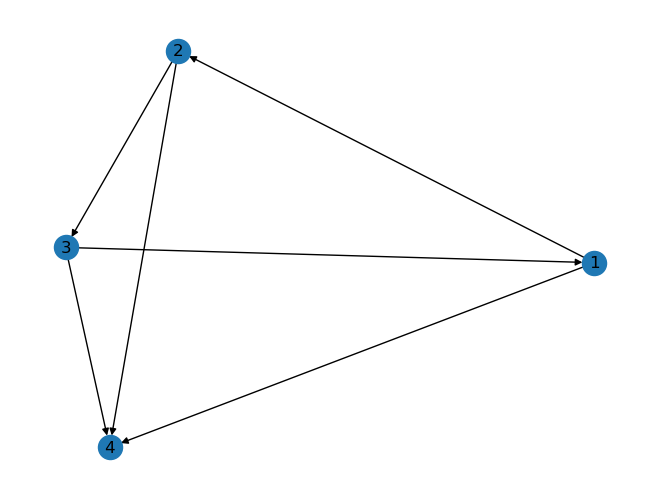

In [2]:
G = nx.DiGraph()
G.add_edges_from([(1, 2), (2, 3), (3, 1), (2, 4), (3, 4), (1, 4)])
pagerank_scores = page_rank(G)
print("PageRank Scores:", pagerank_scores)
nx.draw(G, with_labels=True)
plt.show()

### **Algorithm 2** : A topic sensitive PageRank algorithm - Set up the algorithm
Let $S$ be a collection of integers that represent the row and column numbers of the pages identified as related to a specific topic, known as the teleport set, then the topic sensitive PageRank for $S$ is the limit of the iteration
$$r_j=\sum_{i\rightarrow j}\beta\frac{r_i}{d_i} + (1-\beta)[e_S/|S|]_k$$
where $e_S$ is the vector that has $1$ in the components in $S$ and $0$ in the other components, $|S|$ is the size of set $S$. Or equavilently,
$$r=\beta Mr + (1-\beta)e_S/|S|$$.

In [3]:
def topic_sensitive_page_rank(G, S, beta=0.85, max_iter=100, tol=1e-6):
    n = G.number_of_nodes()
    pr = np.zeros(n)
    nodes = list(G.nodes())
    size_S = len(S)
    
    # Create a vector for e_S
    e_S = np.zeros(n)
    for node in S:
        if node in nodes:
            e_S[nodes.index(node)] = 1  # Set 1 for nodes in S

    for _ in range(max_iter):
        prev_pr = pr.copy()

        # Update PageRank scores
        for j in range(n):
            incoming_links = G.in_edges(nodes[j])
            sum_incoming = sum(prev_pr[nodes.index(i)] / G.out_degree(i) 
                               for i, _ in incoming_links if G.out_degree(i) > 0)

            # Contribution from teleport set
            teleport_contribution = (1 - beta) * (e_S[j] / size_S if size_S > 0 else 0)
            
            pr[j] = beta * sum_incoming + teleport_contribution

        # Check for convergence
        if np.linalg.norm(pr - prev_pr, 1) < tol:
            break
    
    return dict(zip(nodes, pr))

#### Example - Topic Sensitive PageRank

Topic-Sensitive PageRank Scores: {'A': 0.35556608297877496, 'B': 0.22611543267084594, 'C': 0.4183133978459316, 'D': 0.0, 'E': 0.0, 'F': 0.0}


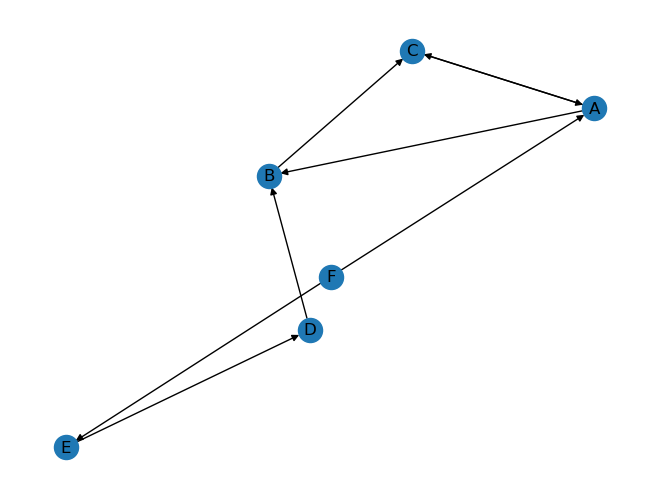

In [4]:
# Topic-Sensitive PageRank
G = nx.DiGraph()
edges = [('A', 'B'), ('A', 'C'), ('B', 'C'), ('C', 'A'), ('D', 'B'), ('E', 'D'), ('F', 'A'), ('F', 'E')]
G.add_edges_from(edges)

# Define the teleport set
teleport_set = ['B', 'C']  # Nodes related to a specific topic

# Calculate PageRank based on the teleport set
pagerank_scores = topic_sensitive_page_rank(G, teleport_set)
print("Topic-Sensitive PageRank Scores:", pagerank_scores)
nx.draw(G, with_labels=True)
plt.show()